In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mpl_toolkits import mplot3d
from numpy import set_printoptions
from numpy import absolute
from numpy import mean
from numpy import std


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.models import model_from_json

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
#from matplotlib import pyplot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
import seaborn as sns
%matplotlib inline

In [2]:
prosody_data = pd.read_csv('Prosodic_Features_Modified.csv ')
turker_score = pd.read_csv('Turker_Scores_Modified.csv')

In [3]:
dA = pd.read_csv('prosodic_features_M2.csv ')
yRH = turker_score['RecommendHiring']
yF = turker_score['Friendly']
ySA = turker_score['StructuredAnswers']
yNS = turker_score['NotStressed']
yNS = turker_score['NotStressed']
yCLG= turker_score['Colleague']
yEXTD = turker_score['Excited']
ySPKR = turker_score['SpeakingRate']
yNF = turker_score['NoFillers']
yPSD = turker_score['Paused']
yENGT = turker_score['EngagingTone']
yCalm = turker_score['Calm']
yNAWKD =turker_score['NotAwkward']
yFOC = turker_score['Focused']

MFOC = turker_score['Focused_M']
MNAWKD =turker_score['NotAwkward_M']
MNS = turker_score['NotStressed_M']
MCalm =  turker_score['Calm_M']
MENGT =  turker_score['EngagingTone_M']
MPSD = turker_score['Paused_M']
MNF =turker_score['NoFillers_M']
MSPKR = turker_score['SpeakingRate_M']
MEXTD = turker_score['Excited_M']
MRH = turker_score['RecommendHiring_M']
MF= turker_score['Friendly_M']
MENG = turker_score['Engaged_M']
MCLG =turker_score['Colleague_M'] 
MSA = turker_score['StructuredAnswers_M']

In [4]:
ranks = {}
from sklearn.preprocessing import MinMaxScaler
 
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    #ranks = map(lambda x: round(x, 5), ranks)
    return dict(zip(names, ranks ))

# Feature Selection Using Kbest

In [5]:
def select_feature_kbest(prosody_data_y):
    array =  prosody_data.values

    X = prosody_data_X
    Y = prosody_data_y
    # feature extraction
    kbest_test = SelectKBest(score_func=f_classif, k=4)
    fit = kbest_test.fit(X, Y)
    # summarize scores
    set_printoptions(precision=3)
    #print(fit.scores_)
    features = fit.transform(X)
    # summarize selected features
    #print(features[0:5,:])

    ranks["kbest"] = rank_to_dict(np.abs(fit.scores_), prosody_data_X)
    rankDict = {}
    rankDict = ranks["kbest"]
    return rankDict

# Feature Selection Using Ridge Regression

In [6]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
# load the dataset
def select_feature_ridge(prosody_data_y):
    array = prosody_data.values
    X=prosody_data_X
    y=prosody_data_y
    # define model
    ridge_model = Ridge(alpha=1.0)
    # define model evaluation method
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    #print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    #print(scores)
    
    ranks["ridge"] = rank_to_dict(np.abs(scores), prosody_data_X)
    rankDict = {}
    rankDict = ranks["ridge"]
    return rankDict

# Feature Selection Using Lasso

In [7]:
from sklearn.linear_model import Lasso 

def select_feature_lasso(prosody_data_y):
    array =  prosody_data.values

    X = prosody_data_X
    y = prosody_data_y
    
    lasso = Lasso(alpha=.5)
    lasso.fit(X, y)

    cross_val_score(lasso, prosody_data_X , prosody_data_y,cv=3)

    ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), prosody_data_X)
    rankDict = {}
    rankDict = ranks['Lasso']
    return rankDict

# Making arrays of Top 10 20 30 Features

In [8]:
def select_features(rankDict):
    selectedFeatures = []

    selectedFeatures = dict(sorted(rankDict.items(), key=lambda item: item[1],reverse=True))


    selectedFeatures_10 = []
    i=0
    for key in selectedFeatures.keys():
        if(i<10):
            selectedFeatures_10.append(key)
            i+=1

    selectedFeatures_20 = []
    i=0
    for key in selectedFeatures.keys():
        if(i<20):
            selectedFeatures_20.append(key)
            i+=1

    selectedFeatures_30 = []
    i=0
    for key in selectedFeatures.keys():
        if(i<30):
            selectedFeatures_30.append(key)
            i+=1
    return selectedFeatures_10,selectedFeatures_20,selectedFeatures_30


In [9]:
prosody_data_X = prosody_data.drop(['participant&question','RecommendHiring'],axis=1)

# Feature selection for RecommendHiring 

In [10]:
prosody_data_y = yRH
X_train, X_test, y_train, y_test = train_test_split(prosody_data_X, prosody_data_y, test_size=0.20, random_state=10)

#using Kbest
selectedFeatures_RecommendHiring_Kbest=select_feature_kbest( prosody_data_y)
print("\nScores of Features for RecommendHiring Using Kbest")
print(selectedFeatures_RecommendHiring_Kbest)

#Using Lasso
selectedFeatures_RecommendHiring_Lasso=select_feature_lasso( prosody_data_y)
print("\nScores of Features for RecommendHiring using Lasso")
print(selectedFeatures_RecommendHiring_Lasso)

#Using Ridge
selectedFeatures_RecommendHiring_Ridge=select_feature_ridge( prosody_data_y)
print("\nScores of Features for RecommendHiring")
print(selectedFeatures_RecommendHiring_Ridge)



Scores of Features for RecommendHiring Using Kbest
{'duration': 0.021639330966149846, 'energy': 0.04134538498387725, 'power': 0.07773660845058039, 'min_pitch': 0.009726004320205253, 'max_pitch': 0.01897088013060464, 'mean_pitch': 0.7990254283105979, 'pitch_sd': 0.1509179731991408, 'pitch_abs': 0.09459515265304856, 'pitch_quant': 1.0000000000000002, 'pitchUvsVRatio': 0.07339564115604419, 'Time:8': 0.021639290243960323, 'iDifference': 0.0011512734988992322, 'diffPitchMaxMin': 0.019859086761528144, 'diffPitchMaxMean': 0.05644312653676563, 'diffPitchMaxMode': 0.06875769416074433, 'intensityMin': 0.070053478329868, 'intensityMax': 0.045101907349622945, 'intensityMean': 0.13874527118743551, 'intensitySD': 0.12735475920688644, 'intensityQuant': 0.1259915385002846, 'diffIntMaxMin': 0.043392305882511674, 'diffIntMaxMean': 0.014950442298704675, 'diffIntMaxMode': 0.016376947337397176, 'avgVal1': 0.0653588164817065, 'avgVal2': 0.10478081489025842, 'avgVal3': 0.0, 'avgBand1': 0.08553649296780874, 

In [11]:
selectedFeatures_kbest_10_RecommendHiring,selectedFeatures_kbest_20_RecommendHiring,selectedFeatures_kbest_30_RecommendHiring= select_features(selectedFeatures_RecommendHiring_Kbest)
print("\n\n\nTop 10 Selected Features Using kbest for RecommendHiring:",selectedFeatures_kbest_10_RecommendHiring )
print("\nTop 20 Selected Features Using kbest for RecommendHiring:",selectedFeatures_kbest_20_RecommendHiring )
print("\nTop 30 Selected Features Using kbest for RecommendHiring:",selectedFeatures_kbest_30_RecommendHiring )


selectedFeatures_lasso_10_RecommendHiring,selectedFeatures_lasso_20_RecommendHiring,selectedFeatures_lasso_30_RecommendHiring= select_features(selectedFeatures_RecommendHiring_Lasso)
print("\n\n\nTop 10 Selected Features for RecommendHiring Using Lasso:",selectedFeatures_lasso_10_RecommendHiring )
print("\nTop 20 Selected Features For RecommendHiring Using Lasso:",selectedFeatures_lasso_20_RecommendHiring)
print("\nTop 30 Selected Features Using For RecommendHiring Using Lasso:",selectedFeatures_lasso_30_RecommendHiring )

selectedFeatures_ridge_10_RecommendHiring,selectedFeatures_ridge_20_RecommendHiring,selectedFeatures_ridge_30_RecommendHiring= select_features(selectedFeatures_RecommendHiring_Ridge)
print("\n\n\nTop 10 Selected Features For RecommendHiring Using ridge :",selectedFeatures_ridge_10_RecommendHiring )
print("\nTop 20 Selected For RecommendHiring Features Using ridge:",selectedFeatures_ridge_20_RecommendHiring )
print("\nTop 30 Selected For RecommendHiring Features Using ridge:",selectedFeatures_ridge_30_RecommendHiring )





Top 10 Selected Features Using kbest for RecommendHiring: ['pitch_quant', 'meanPeriod', 'mean_pitch', 'fmean3', 'f3STD', 'f2STD', 'pitch_sd', 'shimmer', 'avgBand2', 'intensityMean']

Top 20 Selected Features Using kbest for RecommendHiring: ['pitch_quant', 'meanPeriod', 'mean_pitch', 'fmean3', 'f3STD', 'f2STD', 'pitch_sd', 'shimmer', 'avgBand2', 'intensityMean', 'jitter', 'intensitySD', 'intensityQuant', 'jitterRap', 'f1STD', 'avgVal2', 'fmean2', 'PercentBreaks', 'AvgTotFall:3', 'f2STDf1']

Top 30 Selected Features Using kbest for RecommendHiring: ['pitch_quant', 'meanPeriod', 'mean_pitch', 'fmean3', 'f3STD', 'f2STD', 'pitch_sd', 'shimmer', 'avgBand2', 'intensityMean', 'jitter', 'intensitySD', 'intensityQuant', 'jitterRap', 'f1STD', 'avgVal2', 'fmean2', 'PercentBreaks', 'AvgTotFall:3', 'f2STDf1', 'pitch_abs', 'f2STDf2', 'avgBand1', 'percentUnvoiced', 'AvgTotRis:3', 'power', 'pitchUvsVRatio', 'f3meanf1', 'intensityMin', 'diffPitchMaxMode']



Top 10 Selected Features for RecommendHir

# Applying Models

In [12]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)


  ##shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
    # Learn to predict each class against the other
    y_score=estimator.fit(X_train, y_train, epochs=no_of_epochs, batch_size=5, verbose=0)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    
    --pip install -U imbalanced-learn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
    X, y = oversample.fit_resample(X, y)
    # summarize distribution
    counter = Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

In [13]:
def apply_NN_Model(no_of_inNeurons,no_of_hiddenLayerNeurons,no_of_epochs,selectedFeatures_No,d_Var):
    scaler = MinMaxScaler()
    X=prosody_data[selectedFeatures_No].values
    X =  scaler.fit_transform(X)
    Y=d_Var
    
    #encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(Y)
    y = encoder.transform(Y)
    
    
    def baseline_model():
        # create model
        model = Sequential()
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(3, activation='softmax'))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    build_model=baseline_model
    estimator = KerasClassifier(build_model, epochs=no_of_epochs, batch_size=5, verbose=0)
    kfold = KFold(n_splits=10, shuffle=True)
    cv_results = cross_val_score(estimator, X, y, cv=kfold)
    print("Baseline: %.2f%% (%.2f%%)" % (cv_results.mean()*100, cv_results.std()*100))
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    #y_pred= cross_val_predict(estimator, X, y, cv=10)
        
    target_names = ['class 0', 'class 1', 'class 2']
        
    print(classification_report(y_test,y_pred,target_names=target_names, zero_division=0))
       
    
    print('MSE',metrics.mean_squared_error(y_test,y_pred))

    plt.figure(figsize = (10,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True,fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
       
    return cv_results

# Applying Models For RecommendHiring

Baseline: 83.38% (4.26%)
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

     class 0       0.65      0.61      0.63        18
     class 1       0.92      0.89      0.91       110
     class 2       0.54      0.88      0.67         8

    accuracy                           0.85       136
   macro avg       0.70      0.79      0.73       136
weighted avg       0.87      0.85      0.86       136

MSE 0.14705882352941177


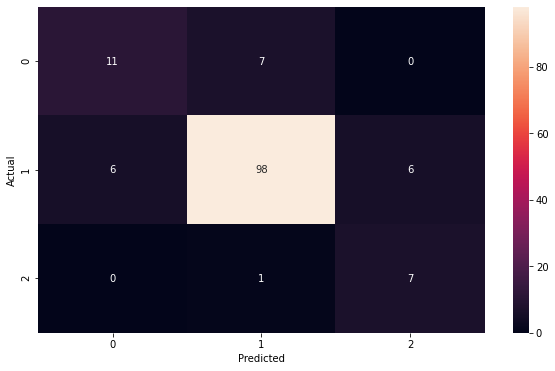

CV_Score Fore kbest_10_RecommendHiring : 83.38% (4.26%)
[83.38235199451447]
Baseline: 83.97% (3.75%)
              precision    recall  f1-score   support

     class 0       0.52      0.67      0.59        18
     class 1       0.92      0.86      0.89       110
     class 2       0.50      0.62      0.56         8

    accuracy                           0.82       136
   macro avg       0.65      0.72      0.68       136
weighted avg       0.84      0.82      0.83       136

MSE 0.19852941176470587


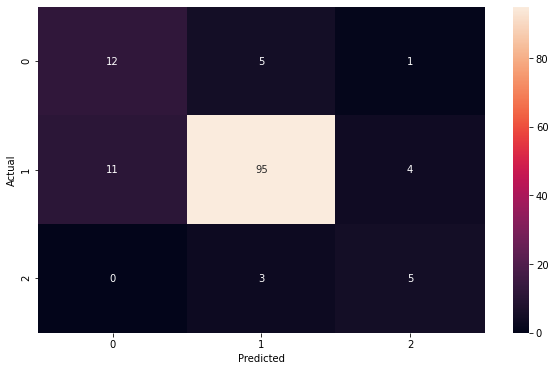

[83.38235199451447, 83.97058844566345]
Baseline: 86.03% (4.22%)
              precision    recall  f1-score   support

     class 0       0.40      0.56      0.47        18
     class 1       0.90      0.83      0.86       110
     class 2       0.60      0.75      0.67         8

    accuracy                           0.79       136
   macro avg       0.63      0.71      0.66       136
weighted avg       0.82      0.79      0.80       136

MSE 0.21323529411764705


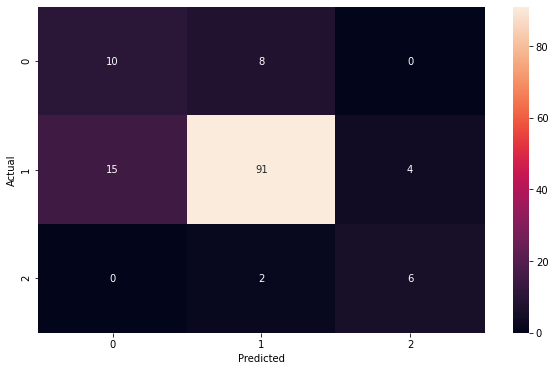

[83.38235199451447, 83.97058844566345, 86.02941155433655]


In [14]:
cvscores_NN_RecommendHiring= []
#Using Kbest
#(model_NN_10_kbest,cvscores_NN_10_kbest,FP_Rate_NN_10_kbest,TP_Rate_NN_10_kbest,auc_NN_10_kbest_) = 
cvscore_NN_10_kbest_RecommendHiring= apply_NN_Model(10,18,200,selectedFeatures_kbest_10_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_10_kbest_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_10_kbest_RecommendHiring.std()*100)
print("CV_Score Fore kbest_10_RecommendHiring : %.2f%% (%.2f%%)" % (cv_MeanVal,cv_sdVal ))
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)

cvscore_NN_20_kbest_RecommendHiring =apply_NN_Model(20,18,200,selectedFeatures_kbest_20_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_20_kbest_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_20_kbest_RecommendHiring.std()*100)
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)


cvscore_NN_30_kbest_RecommendHiring =apply_NN_Model(30,24,200,selectedFeatures_kbest_30_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_30_kbest_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_30_kbest_RecommendHiring.std()*100)
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)


Baseline: 78.38% (7.15%)
              precision    recall  f1-score   support

     class 0       0.70      0.39      0.50        18
     class 1       0.88      0.96      0.92       110
     class 2       0.83      0.62      0.71         8

    accuracy                           0.87       136
   macro avg       0.81      0.66      0.71       136
weighted avg       0.86      0.87      0.85       136

MSE 0.1323529411764706


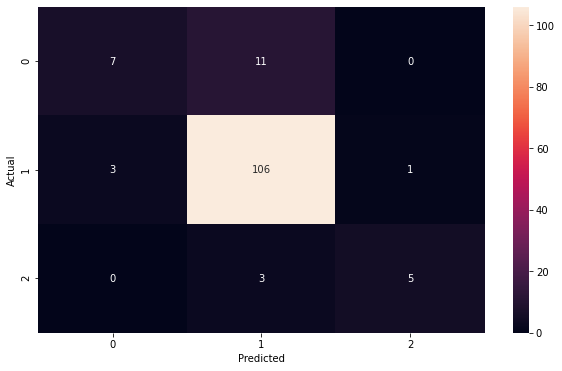

CV_Score Fore lasso_10_RecommendHiring : 78.38% (7.15%)
[83.38235199451447, 83.97058844566345, 86.02941155433655, 78.38235259056091]
Baseline: 77.94% (3.42%)
              precision    recall  f1-score   support

     class 0       0.45      0.50      0.47        18
     class 1       0.88      0.85      0.87       110
     class 2       0.33      0.38      0.35         8

    accuracy                           0.78       136
   macro avg       0.55      0.58      0.56       136
weighted avg       0.79      0.78      0.78       136

MSE 0.2426470588235294


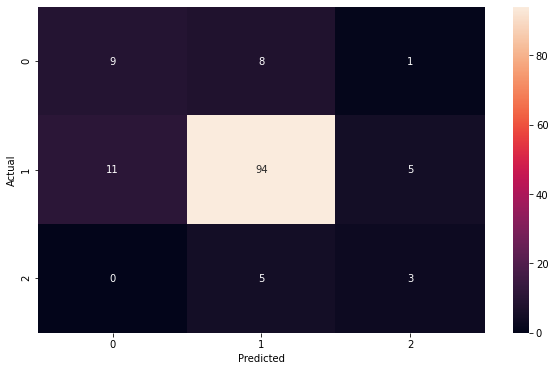

[83.38235199451447, 83.97058844566345, 86.02941155433655, 78.38235259056091, 77.9411768913269]
Baseline: 81.91% (4.70%)
              precision    recall  f1-score   support

     class 0       0.65      0.61      0.63        18
     class 1       0.91      0.92      0.91       110
     class 2       0.62      0.62      0.62         8

    accuracy                           0.86       136
   macro avg       0.73      0.72      0.72       136
weighted avg       0.86      0.86      0.86       136

MSE 0.13970588235294118


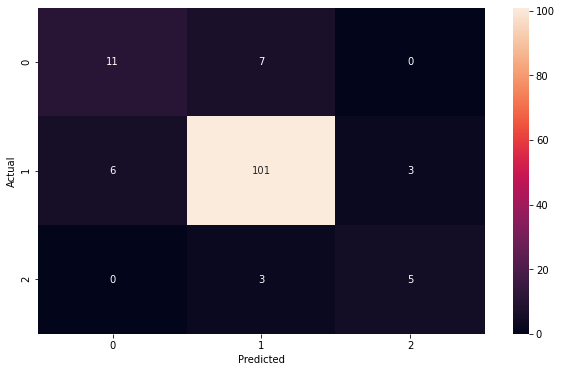

[83.38235199451447, 83.97058844566345, 86.02941155433655, 78.38235259056091, 77.9411768913269, 81.91176414489746]


In [15]:
#using Lasso
cvscore_NN_10_lasso_RecommendHiring = apply_NN_Model(10,18,200,selectedFeatures_lasso_10_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_10_lasso_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_10_lasso_RecommendHiring.std()*100)
print("CV_Score Fore lasso_10_RecommendHiring : %.2f%% (%.2f%%)" % (cv_MeanVal,cv_sdVal ))
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)

cvscore_NN_20_lasso_RecommendHiring =apply_NN_Model(20,18,200,selectedFeatures_lasso_20_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_20_lasso_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_20_lasso_RecommendHiring.std()*100)
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)


cvscore_NN_30_lasso_RecommendHiring =apply_NN_Model(30,24,200,selectedFeatures_lasso_30_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_30_lasso_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_30_lasso_RecommendHiring.std()*100)
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)



Baseline: 79.71% (2.44%)
              precision    recall  f1-score   support

     class 0       0.75      0.33      0.46        18
     class 1       0.88      0.95      0.91       110
     class 2       0.62      0.62      0.62         8

    accuracy                           0.85       136
   macro avg       0.75      0.64      0.67       136
weighted avg       0.84      0.85      0.84       136

MSE 0.14705882352941177


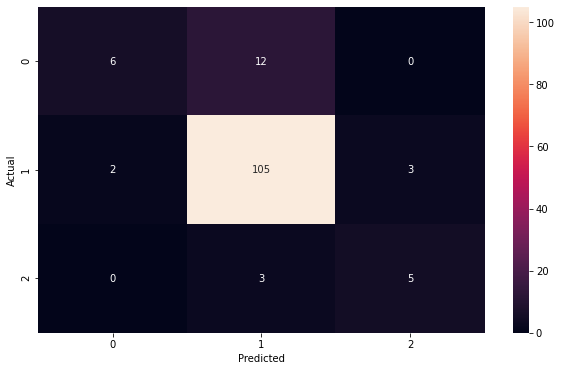

CV_Score Fore ridge_10_RecommendHiring : 79.71% (2.44%)
[83.38235199451447, 83.97058844566345, 86.02941155433655, 78.38235259056091, 77.9411768913269, 81.91176414489746, 79.70588266849518]
Baseline: 79.56% (6.53%)
              precision    recall  f1-score   support

     class 0       0.41      0.50      0.45        18
     class 1       0.86      0.86      0.86       110
     class 2       0.33      0.12      0.18         8

    accuracy                           0.77       136
   macro avg       0.53      0.50      0.50       136
weighted avg       0.77      0.77      0.77       136

MSE 0.22794117647058823


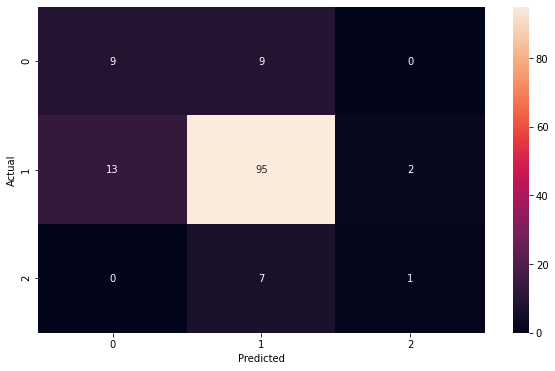

[83.38235199451447, 83.97058844566345, 86.02941155433655, 78.38235259056091, 77.9411768913269, 81.91176414489746, 79.70588266849518, 79.55882370471954]
Baseline: 82.21% (3.18%)
              precision    recall  f1-score   support

     class 0       0.71      0.28      0.40        18
     class 1       0.87      0.96      0.91       110
     class 2       0.57      0.50      0.53         8

    accuracy                           0.85       136
   macro avg       0.72      0.58      0.62       136
weighted avg       0.83      0.85      0.82       136

MSE 0.17647058823529413


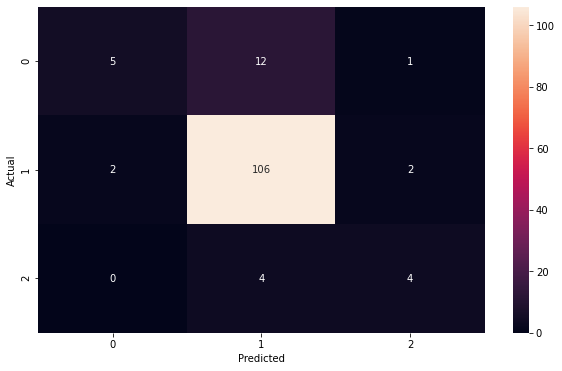

[83.38235199451447, 83.97058844566345, 86.02941155433655, 78.38235259056091, 77.9411768913269, 81.91176414489746, 79.70588266849518, 79.55882370471954, 82.20588326454163]


In [16]:
#using Ridge
cvscore_NN_10_ridge_RecommendHiring = apply_NN_Model(10,18,200,selectedFeatures_ridge_10_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_10_ridge_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_10_ridge_RecommendHiring.std()*100)
print("CV_Score Fore ridge_10_RecommendHiring : %.2f%% (%.2f%%)" % (cv_MeanVal,cv_sdVal ))
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)

cvscore_NN_20_ridge_RecommendHiring =apply_NN_Model(20,18,200,selectedFeatures_ridge_20_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_20_ridge_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_20_ridge_RecommendHiring.std()*100)
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)


cvscore_NN_30_ridge_RecommendHiring =apply_NN_Model(30,24,200,selectedFeatures_ridge_30_RecommendHiring,MRH)
cv_MeanVal =(cvscore_NN_30_ridge_RecommendHiring.mean()*100) 
cv_sdVal = (cvscore_NN_30_ridge_RecommendHiring.std()*100)
cvscores_NN_RecommendHiring.append(cv_MeanVal)
print(cvscores_NN_RecommendHiring)


In [17]:
print(max(cvscores_NN_RecommendHiring))

86.02941155433655


In [66]:

#define and fit the final model for rcommend Hiring

X=prosody_data

Y = MRH
#encode class values as integers


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=10)

X_train

,participant&question,duration,energy,power,min_pitch,max_pitch,mean_pitch,pitch_sd,pitch_abs,pitch_quant,...,avgDurPause,TotDurPause:3,iInterval,MaxRising:3,MaxFalling:3,AvgTotRis:3,AvgTotFall:3,numRising,numFall,RecommendHiring
69,P16Q5,49.786917,0.008120,0.000163,81.948120,395.408314,224.134131,37.521671,227.881697,214.856718,...,0.708,30.451,109,292.064,176.325,26.440,16.384,72,3718.338856,5.347201
452,PP30Q3,64.018542,0.001112,0.000017,73.765098,399.855270,160.828977,62.536724,175.256672,171.890137,...,1.164,45.397,118,225.559,202.002,27.669,29.815,61,578.182387,3.489503
609,PP71Q5,37.252542,0.002706,0.000073,70.563938,321.314846,208.435433,41.241302,274.983145,212.444069,...,0.520,18.187,101,185.437,141.110,33.663,14.564,69,3214.152024,5.106477
97,P25Q3,150.074229,0.041717,0.000278,68.369862,377.928726,200.369366,63.714384,459.775950,213.415721,...,0.658,92.056,538,286.138,252.955,42.996,39.537,283,25525.019160,4.867697
614,PP72Q5,19.080729,0.002248,0.000118,77.365245,324.774702,206.067899,36.143250,287.807035,204.822899,...,0.463,9.728,49,141.767,152.153,24.758,12.717,38,1118.006514,5.348370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,PP7Q5,17.072271,0.001406,0.000082,91.630793,250.149561,117.162491,21.060574,172.176761,110.662391,...,0.495,6.933,53,142.323,136.892,15.914,13.513,36,1716.728552,5.447008
320,P84Q1,37.902604,0.003352,0.000088,72.099955,393.036319,201.011915,45.285851,319.581688,210.863371,...,0.459,17.909,94,156.152,182.853,27.988,26.476,58,3613.956286,6.282060
527,PP52Q3,108.263479,0.005758,0.000053,72.407345,369.574753,102.662746,20.374131,110.242911,98.119176,...,0.577,58.325,253,279.441,261.638,14.230,12.546,151,10213.220870,3.962509
125,P33Q1,51.678875,0.006552,0.000127,66.563609,397.211098,178.133275,47.046231,266.010303,164.031120,...,0.619,29.706,129,160.827,190.586,29.651,22.798,74,5516.561642,5.017387


In [72]:

#define and fit the final model for rcommend Hiring

X= prosody_data_X

Y_RH=MRH
Y_F=MF
Y_Calm=MCalm
Y_ENGT=MENGT
#encode class values as integers


X_train, X_test, y_RH_train, y_RH_test = train_test_split(X, Y_RH, test_size=0.20, random_state=10)
X_train, X_test, y_F_train, y_F_test = train_test_split(X, Y_F, test_size=0.20, random_state=10)
X_train, X_test, y_Calm_train, y_Calm_test = train_test_split(X, Y_Calm, test_size=0.20, random_state=10)
X_train, X_test, y_ENGT_train, y_ENGT_test = train_test_split(X, Y_ENGT, test_size=0.20, random_state=10)

X_train

[1, 2, 3] [4, 5, 6]


In [60]:
def baseline_model(no_of_hiddenLayerNeurons=24,no_of_inNeurons=30):
    # create model
    model = Sequential()
    model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
    model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
    model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
    model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
    model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


build_model=baseline_model


#For selecing recommend Hiring
scaler = MinMaxScaler()
X_train_RH = X_train[selectedFeatures_kbest_30_RecommendHiring].values
X_train_RH = scaler.fit_transform(X_train_RH)

X_test_RH = X_test[selectedFeatures_kbest_30_RecommendHiring].values
X_test_RH = scaler.fit_transform(X_test_RH)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_RH = encoder.transform(y_train)
estimator = KerasClassifier(build_model, epochs=200, batch_size=5, verbose=0)
estimator.fit(X_train_RH, y_train_RH)
y_test_RH =  y_test
y_pred_RH = estimator.predict(X_test_RH)
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test_RH,y_pred_RH,target_names=target_names, zero_division=0))
RH= []
for i in y_pred_RH:
    if(y_pred_RH[i] == 2):
        RH.append('Higly Recommended')
    elif(y_pred_RH[i] == 1):
        RH.append('Average Recommended')
    else:
        RH.append('Not Recommended')
    
print(RH)
    

KeyboardInterrupt: 

In [79]:
def Predict_Results(no_of_inNeurons,no_of_hiddenLayerNeurons,selectedFeatures_in,X_In,Y_In):

    # create model
    def baseline_model():
        model = Sequential()
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(no_of_hiddenLayerNeurons, input_dim=no_of_inNeurons, activation='relu'))
        model.add(Dense(3, activation='softmax'))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    


    build_model=baseline_model

    X= X_In
    Y= Y_In
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=10)
    #For selecing recommend Hiring
    scaler = MinMaxScaler()
    X_train = X_train[selectedFeatures_in].values
    X_train = scaler.fit_transform(X_train)

    X_test = X_test[selectedFeatures_in].values
    X_test = scaler.fit_transform(X_test)

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    
    estimator = KerasClassifier(build_model, epochs=200, batch_size=5, verbose=0)
    estimator.fit(X_train, y_train)
    
    y_pred = estimator.predict(X_test)
    
    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(y_test,y_pred,target_names=target_names, zero_division=0))
    
    Results= []
    for i in y_pred_RH:
        if(y_pred[i] == 2):
            Results.append('Higly ')
        elif(y_pred[i] == 1):
            Results.append('Average')
        else:
            Results.append('Not')

    print(Results)
    return Results

In [80]:
RH= []
RH =  Predict_Results(30,24,selectedFeatures_kbest_30_RecommendHiring,prosody_data_X,MRH)


              precision    recall  f1-score   support

     class 0       0.65      0.72      0.68        18
     class 1       0.92      0.91      0.91       110
     class 2       0.57      0.50      0.53         8

    accuracy                           0.86       136
   macro avg       0.71      0.71      0.71       136
weighted avg       0.86      0.86      0.86       136

['Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'Average', 'A

In [82]:
PR_Calm= []
PR_Calm =  Predict_Results(30,24,selectedFeatures_kbest_30_Calm,prosody_data_X,MCalm)

NameError: name 'selectedFeatures_kbest_30_Calm' is not defined

In [ ]:
PR_ENDT= []
PR_ENDT =  Predict_Results(30,24,selectedFeatures_kbest_30_ENDT,prosody_data_X,MENDT)

In [ ]:
PR_CLG= []
PR_CLG =  Predict_Results(30,24,selectedFeatures_kbest_30_CLG,prosody_data_X,MCLG)

In [ ]:
PR_NS= []
PR_NS =  Predict_Results(30,24,selectedFeatures_kbest_30_NS,prosody_data_X,MNS)